In [1]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import treelib
import networkx as nx
import numpy as np

# sys.path.insert(0, '../generation/')
import esr.generation.simplifier as simplifier
import esr.generation.generator as generator

rcParams['text.usetex'] = True

In [2]:
rcParams['text.usetex'] = True

def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.
    Licensed under Creative Commons Attribution-Share Alike
    
    If the graph is a tree this will return the positions to plot this in a
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch
    - if the tree is directed and this is not given,
      the root will be found and used
    - if the tree is directed and this is given, then
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given,
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)
        if len(children)!=0:
            dx = width/len(children)
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap,
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)
    
def make_tree(tree, i, names):
    
    tree[i].tree = treelib.Tree()
    
    # Check for duplicate node names
    if tree[i].op in names:
        n = [a for a in names if a.startswith(tree[i].op)]
        tree[i].node_name = tree[i].op + str(len(n))
    else:
        tree[i].node_name = tree[i].op
    
    # Name and label of node
    if tree[i].val is None:
        tree[i].tree.create_node(tree[i].op, tree[i].node_name)
    else:
        tree[i].tree.create_node(str(tree[i].val), tree[i].node_name)
        
    # Store node names
    n2 = names.copy()
    n2 += [tree[i].node_name]
    
    if tree[i].type > 0:
        tree = make_tree(tree, tree[i].left, n2)
        n2 += list(tree[tree[i].left].tree.nodes.keys())
        tree[i].tree.paste(tree[i].node_name, tree[tree[i].left].tree)
    if tree[i].type > 1:
        tree = make_tree(tree, tree[i].right, n2)
        n2 += list(tree[tree[i].right].tree.nodes.keys())
        tree[i].tree.paste(tree[i].node_name, tree[tree[i].right].tree)
        
    return tree

def make_fig(labels, tex_str, fig, ax, set_title=True, title_size=10):

    basis_functions = [["x", "a", "n0"],  # type0
                    ["square", "exp", "inv", "sqrt", "log", "n1"],  # type1
                    ["+", "*", "-", "/", "pow", "n2"]]  # type2

    s = []

    for l in labels:
        if l.lstrip("-").isdigit() or (l.startswith('a') and l[1:].isdigit()):
            s.append(0)
        else:
            for i in range(len(basis_functions)):
                if l in basis_functions[i]:
                    s.append(i)

    success, part_considered, tree = generator.check_tree(s)
    fstr = generator.node_to_string(0, tree, labels)
    max_param = max(1, len([a for a in labels if a.startswith('a')]))
    
    if set_title:
        fstr, fsym = simplifier.initial_sympify([fstr], max_param, verbose=False)
        fsym = fsym[fstr[0]]
    
    for i in range(len(tree)):
        tree[i].assign_op(labels[i])

    make_tree(tree, 0, [])

    G = nx.Graph()

    # Add all nodes to graph
    for n in list(tree[0].tree.nodes.keys()):
        G.add_node(n)

    # Node labels
    labs = {}
    for k in tree[0].tree.nodes.keys():
        if k.startswith('a') and k[1:].isdigit():
            labs[k] = r'$\theta_{%s}$'%tree[0].tree.nodes[k].tag[1:]
        elif k.startswith('n') and k[1:].isdigit():
            labs[k] = r'$%s$'%tree[0].tree.nodes[k].tag[1:]
        elif tree[0].tree.nodes[k].tag == 'x':
            labs[k] = r'$%s$'%tree[0].tree.nodes[k].tag
        elif '_' in k:
            i = k.index('_')
            labs[k] = r'${\rm %s\_%s}$'%(tree[0].tree.nodes[k].tag[:i], tree[0].tree.nodes[k].tag[i+1:])
        else:
            labs[k] = r'${\rm %s}$'%tree[0].tree.nodes[k].tag

    # Add all edges to graph
    if tree[0].tree.nodes:
        for n in tree[0].tree.expand_tree(mode=tree[0].tree.WIDTH):
            nid = tree[0].tree[n].identifier

            for c in tree[0].tree.children(nid):
                cid = c.identifier
                G.add_edge(nid, cid)

    pos = hierarchy_pos(G, tree[0].tree.root)
    
    nx.draw(G, pos=pos,
            with_labels=True,
            labels=labs,
            node_size=900,
            node_color=[(95/256, 190/256, 220/256)],
            edgecolors='k',
            ax=ax)

    if set_title:
        t = [labs[a] for a in labels]
        t = '[' + ', '.join(t) + ']'
        t = r'%s'%t
        t = tex_str + ' = ' + t
        ax.set_title(t, fontsize=title_size)
    
    return

# Tree Representation

Example of a tree as a string

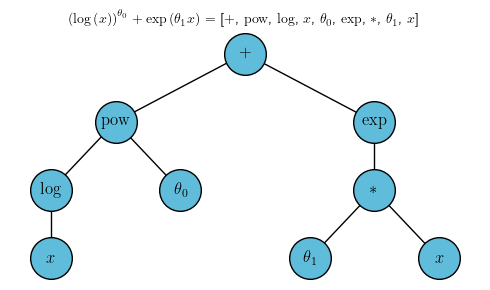

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(5,3))
labels = ["+", "pow", "log", "x", "a0", "exp", "*", "a1", "x"]
tex_str = r'$\left(\log\left(x\right)\right)^{\theta_0}+ \exp\left( \theta_1 x \right)$'
make_fig(labels, tex_str, fig, ax, set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/example_tree.pdf', bbox_inches='tight', transparent=True)

All possible trees at complexity 4

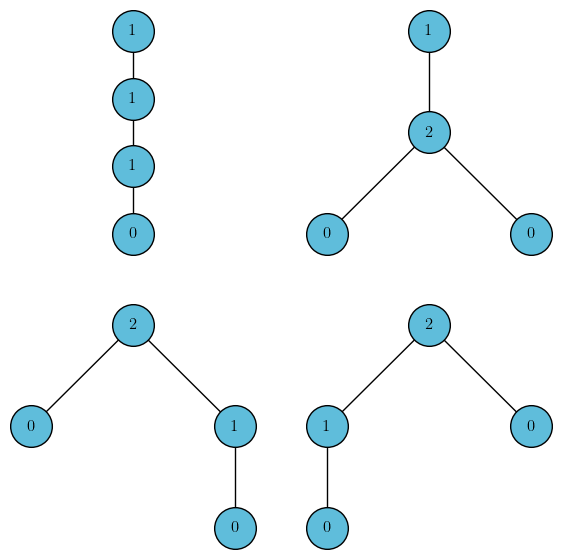

In [123]:
all_shape = [[1,1,1,0],
            [1,2,0,0],
             [2,0,1,0],
            [2,1,0,0]]
fig, axs = plt.subplots(2, 2, figsize=(7,7))
axs = axs.flatten()
for i, s in enumerate(all_shape):
    labels = ['n' + str(ss) for ss in s]
    tex_str = ''
    make_fig(labels, tex_str, fig, axs[i], set_title=False)
fig.savefig('pres_plots/valid_trees_4.pdf', bbox_inches='tight', transparent=True)

# Duplicate Checking and Simplifications

Tree Reordering

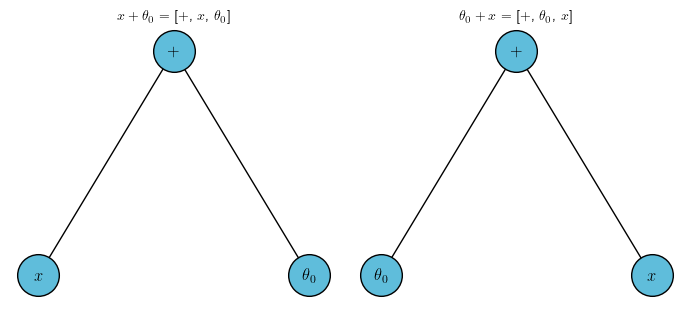

In [143]:
labels_1 = ["+", "x", "a0"]
tex_str_1 = r'$x + \theta_0$'

labels_2 = ["+", "a0", "x"]
tex_str_2 = r'$\theta_0 + x$'

fig, axs = plt.subplots(1, 2, figsize=(7,3.2))
make_fig(labels_1, tex_str_1, fig, axs[0], set_title=True)
make_fig(labels_2, tex_str_2, fig, axs[1], set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/tree_reordering.pdf', bbox_inches='tight', transparent=True)

Simplifications

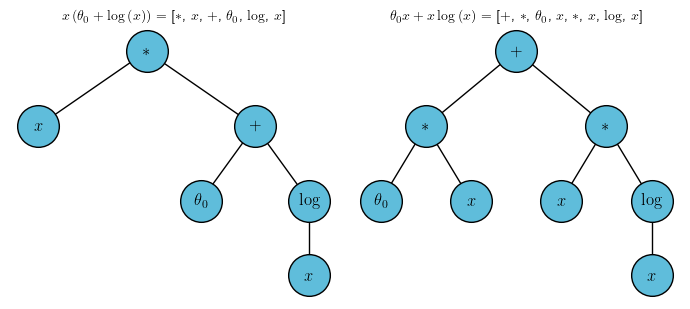

In [125]:
labels_1 = ["*", "x", "+", "a0", "log", "x"]
tex_str_1 = r'$x \left( \theta_0 + \log \left( x \right) \right)$'

labels_2 = ["+", "*", "a0", "x", "*", "x", "log", "x"]
tex_str_2 = r'$\theta_0 x + x \log \left( x \right)$'

fig, axs = plt.subplots(1, 2, figsize=(7,3.2))
make_fig(labels_1, tex_str_1, fig, axs[0], set_title=True)
make_fig(labels_2, tex_str_2, fig, axs[1], set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/tree_simplifications.pdf', bbox_inches='tight', transparent=True)

Parameter permutations

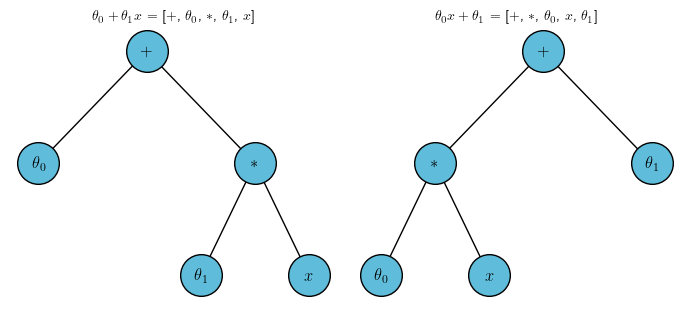

In [126]:
labels_1 = ["+", "a0", "*", "a1", "x"]
tex_str_1 = r'$\theta_0 + \theta_1 x $'

labels_2 = ["+", "*", "a0", "x", "a1"]
tex_str_2 = r'$\theta_0 x  + \theta_1$'

fig, axs = plt.subplots(1, 2, figsize=(7,3.2))
make_fig(labels_1, tex_str_1, fig, axs[0], set_title=True)
make_fig(labels_2, tex_str_2, fig, axs[1], set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/tree_permutations.pdf', bbox_inches='tight', transparent=True)

Reparametrisation

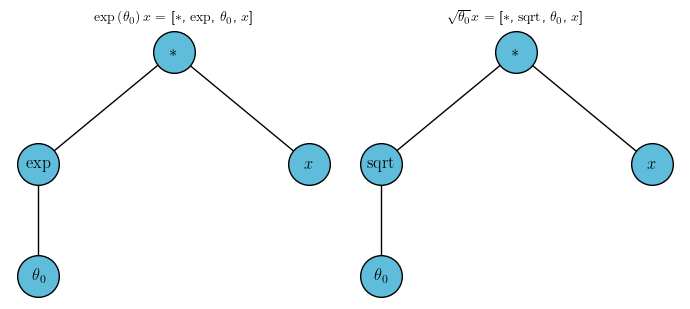

In [127]:
labels_1 = ["*", "exp", "a0", "x"]
tex_str_1 = r'$\exp\left(\theta_0\right) x$'

labels_2 = ["*", "sqrt", "a0", "x"]
tex_str_2 = r'$\sqrt{\theta_0} x$'

fig, axs = plt.subplots(1, 2, figsize=(7,3.2))
make_fig(labels_1, tex_str_1, fig, axs[0], set_title=True)
make_fig(labels_2, tex_str_2, fig, axs[1], set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/tree_reparam.pdf', bbox_inches='tight', transparent=True)

Parameter combinations

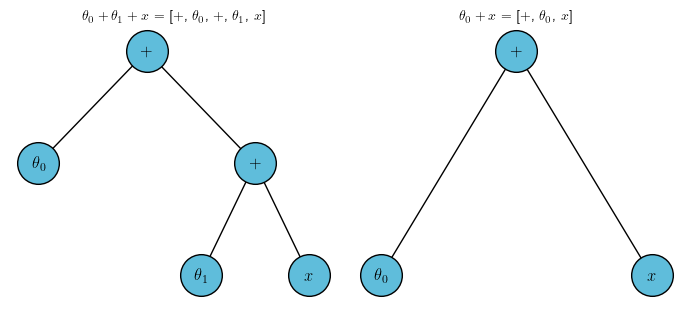

In [128]:
labels_1 = ["+", "a0", "+", "a1", "x"]
tex_str_1 = r'$\theta_0 + \theta_1 + x$'

labels_2 = ["+", "a0", "x"]
tex_str_2 = r'$\theta_0 + x$'

fig, axs = plt.subplots(1, 2, figsize=(7,3.2))
make_fig(labels_1, tex_str_1, fig, axs[0], set_title=True)
make_fig(labels_2, tex_str_2, fig, axs[1], set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/tree_combinations.pdf', bbox_inches='tight', transparent=True)

# Useful Functions

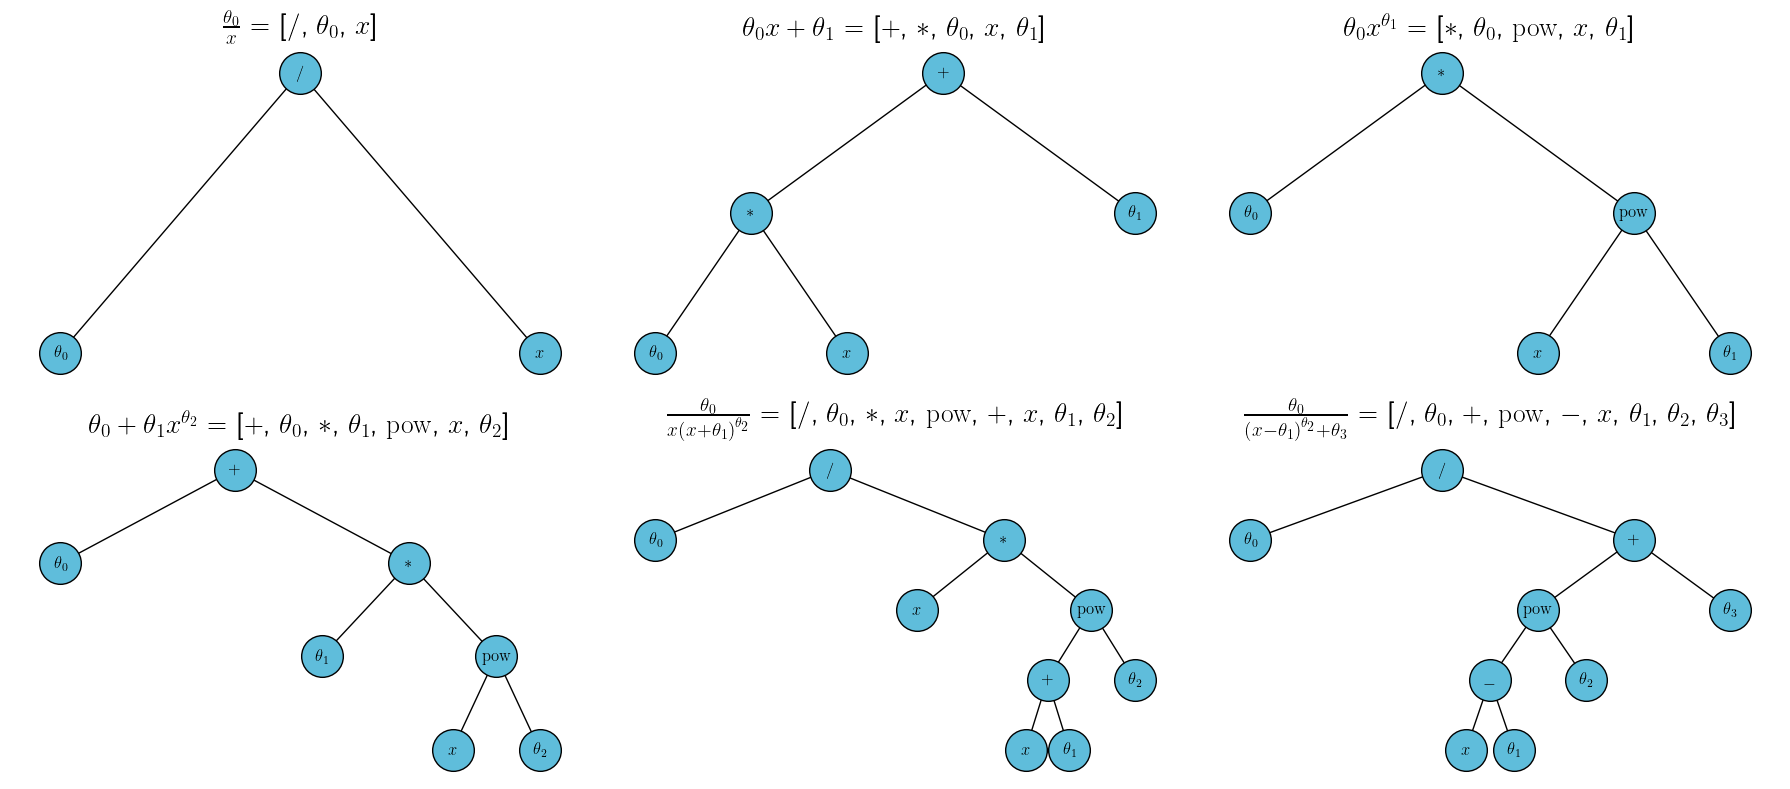

In [139]:
fig, axs = plt.subplots(2, 3, figsize=(18,8))
axs = axs.flatten()
title_size = 20

# Newtonian gravity
labels = ["/", "a0", "x"]
tex_str = r'$\frac{\theta_0}{x}$'
make_fig(labels, tex_str, fig, axs[0], set_title=True, title_size=title_size)

# Straight line
labels = ["+", "*", "a0", "x", "a1"]
tex_str = r'$\theta_0 x + \theta_1$'
make_fig(labels, tex_str, fig, axs[1], set_title=True, title_size=title_size)

# Power law
labels = ["*", "a0", "pow", "x", "a1"]
tex_str = r'$\theta_0 x^{\theta_1}$'
make_fig(labels, tex_str, fig, axs[2], set_title=True, title_size=title_size)

# Friedmann
labels = ["+", "a0", "*", "a1", "pow", "x", "a2"]
tex_str = r'$\theta_0 + \theta_1 x^{\theta_2}$'
make_fig(labels, tex_str, fig, axs[3], set_title=True, title_size=title_size)

# NFW profile
labels = ["/", "a0", "*", "x", "pow", "+", "x", "a1", "a2"]
tex_str = r'$\frac{\theta_0}{x \left( x + \theta_1 \right)^{\theta_2}}$'
make_fig(labels, tex_str, fig, axs[4], set_title=True, title_size=title_size)

# Cauch-Lorentz
labels = ["/", "a0", "+", "pow", "-", "x", "a1", "a2", "a3"]
tex_str = r'$\frac{\theta_0}{\left( x - \theta_1 \right)^{\theta_2} + \theta_3}$'
make_fig(labels, tex_str, fig, axs[5], set_title=True, title_size=title_size)

fig.tight_layout()
fig.savefig('pres_plots/useful_functions.pdf', bbox_inches='tight', transparent=True)

Friedmann again

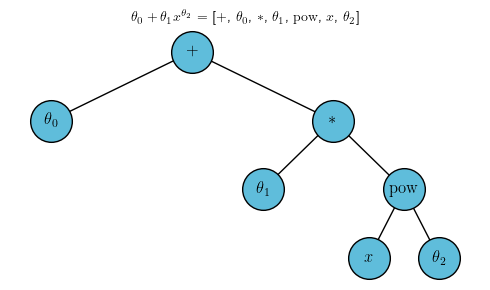

In [22]:
# Friedmann
fig, ax = plt.subplots(1, 1, figsize=(5,3))
labels = ["+", "a0", "*", "a1", "pow", "x", "a2"]
tex_str = r'$\theta_0 + \theta_1 x^{\theta_2}$'
make_fig(labels, tex_str, fig, ax, set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/friedmann.pdf', bbox_inches='tight', transparent=True)

# Pareto Front

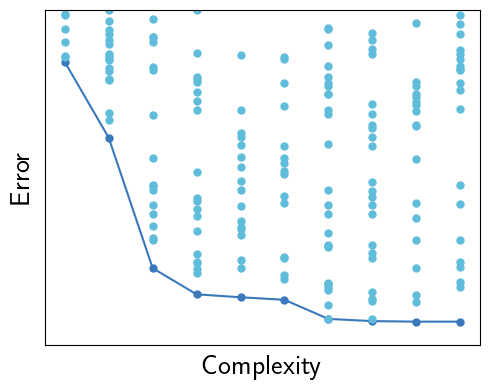

In [37]:
fig, ax = plt.subplots(figsize=(5,4))

np.random.seed(3)

x = np.arange(0, 10)
ymin = 0
ymax = 2
ypareto = np.empty(len(x))

# Make Pareto front
ypareto[0] = np.random.uniform(ymin, ymax)
for i in range(1, len(x)):
    ypareto[i] = np.random.uniform(ymin, ypareto[i-1])
ax.plot(x, ypareto, marker='.', ms=10, c=(57/256, 120/256, 188/256))

# Get feasible points
nfeas = 30
for i in range(len(x)):
    yfeas = np.random.uniform(ypareto[i], ymax, nfeas)
    ax.plot([x[i]]*nfeas, yfeas, '.', ms=10, c=(95/256, 190/256, 220/256))
ax.set_ylim(None, ypareto[0] * 1.2)

ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel(r'Complexity', fontsize=20)
ax.set_ylabel(r'Error', fontsize=20)

fig.tight_layout()
fig.savefig('pres_plots/basic_pareto_front.pdf', bbox_inches='tight', transparent=True)

# Genetic Algorithms

Mutation

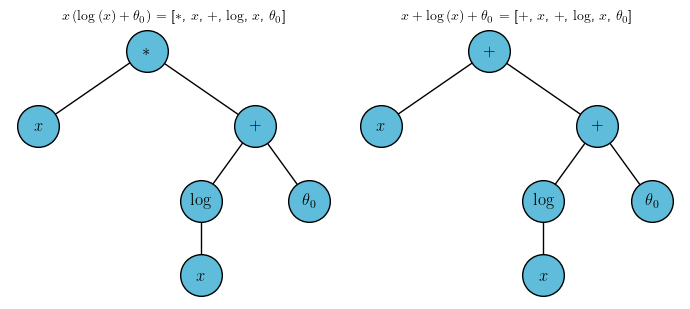

In [19]:
labels_1 = ["*", "x", "+", "log", "x", "a0"]
tex_str_1 = r'$x \left( \log\left( x \right) + \theta_0 \right)$'

labels_2 = ["+", "x", "+", "log", "x", "a0"]
tex_str_2 = r'$x + \log\left( x \right) + \theta_0$'

fig, axs = plt.subplots(1, 2, figsize=(7,3.2))
make_fig(labels_1, tex_str_1, fig, axs[0], set_title=True)
make_fig(labels_2, tex_str_2, fig, axs[1], set_title=True)
fig.tight_layout()
fig.savefig('pres_plots/ga_mutation.pdf', bbox_inches='tight', transparent=True)

Breeding

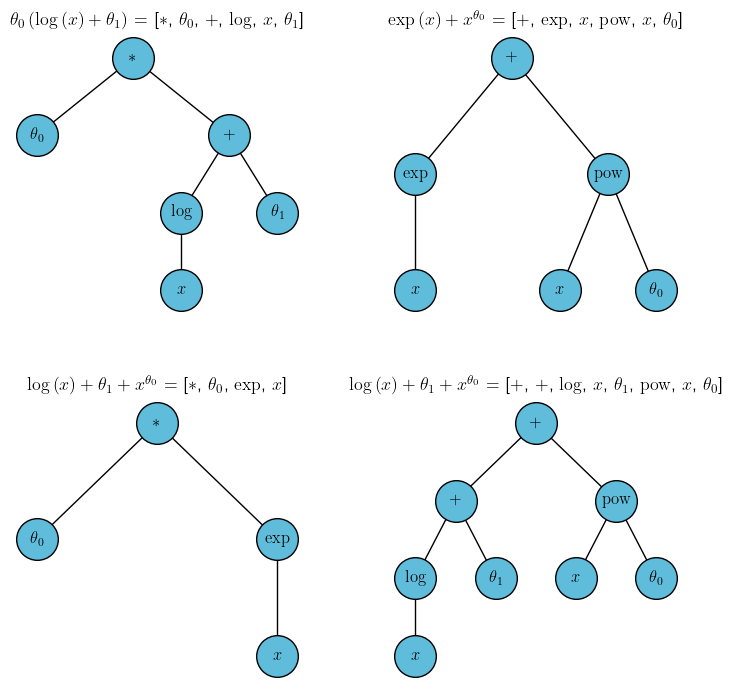

In [20]:
title_size = 13

labels_1 = ["*", "a0", "+", "log", "x", "a1"]
tex_str_1 = r'$\theta_0 \left( \log\left( x \right) + \theta_1 \right)$'

labels_2 = ["+", "exp", "x", "pow", "x", "a0"]
tex_str_2 = r'$\exp \left( x \right) + x^{\theta_0}$'

labels_3 = ["*", "a0", "exp", "x"]
tex_str_3 = r'$\theta_0 \exp \left( x \right)$'

labels_4 = ["+", "+", "log", "x", "a1", "pow", "x", "a0"]
tex_str_4 = r'$\log\left( x \right) + \theta_1 + x^{\theta_0}$'

fig, axs = plt.subplots(2, 2, figsize=(7,7))
make_fig(labels_1, tex_str_1, fig, axs[0,0], set_title=True, title_size=title_size)
make_fig(labels_2, tex_str_2, fig, axs[0,1], set_title=True, title_size=title_size)
make_fig(labels_3, tex_str_4, fig, axs[1,0], set_title=True, title_size=title_size)
make_fig(labels_4, tex_str_4, fig, axs[1,1], set_title=True, title_size=title_size)
fig.tight_layout()
fig.subplots_adjust(wspace=0.3, hspace=0.3)
fig.savefig('pres_plots/ga_breeding.pdf', bbox_inches='tight', transparent=True)

# Fit a straight line

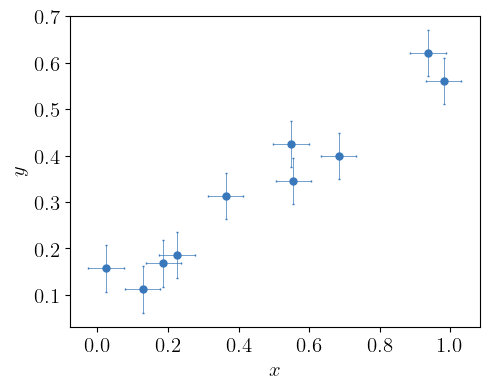

In [38]:
fig, ax = plt.subplots(figsize=(5,4))

np.random.seed(3)
xmin = 0
xmax = 1
nx = 10
a = 0.5
b = 0.1
sigx = 0.05
sigy = 0.05

x = np.random.uniform(xmin, xmax, nx)
y = a * x + b
x = np.random.normal(x, sigx)
y = np.random.normal(y, sigy)

plot_kwargs = {'fmt':'.',
                'markersize':10,
                'zorder':-1, 
                'capsize':1,
                'elinewidth':0.5,
                'color':(57/256, 120/256, 188/256),
                'alpha':1}

ax.errorbar(x, y, xerr=sigx, yerr=sigy, **plot_kwargs)

ax.set_xlabel(r'$x$', fontsize=15)
ax.set_ylabel(r'$y$', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=15)

fig.tight_layout()
fig.savefig('pres_plots/scatter_plot.pdf', bbox_inches='tight', transparent=True)